Importing the required packages

In [1]:
import numpy as np
import pandas as pd

Import the data

In [2]:
df_train = pd.read_csv('datasets_1008_1818_train.csv')
df_train.head()

,Unnamed: 0,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


In [3]:
from io import StringIO
col = ['same_security', 'description_x']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['description_x'])]
df_train.columns = ['same_security', 'description_x']

df_train['category_id'] = df_train['same_security'].factorize()[0]

category_id_df_train = df_train[['same_security', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'same_security']].values)

df_train.head()

,same_security,description_x,category_id
0,True,first trust dow jones internet,0
1,True,schwab intl large company index etf,0
2,False,vanguard small cap index adm,1
3,True,duke energy corp new com new isin #us4 sedol #...,0
4,True,visa inc class a,0


Create a new column called "text length" which is the number of words in the text column.

In [4]:
df_train['text length']=df_train['description_x'].apply(len)

The data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Use FacetGrid from the seaborn library

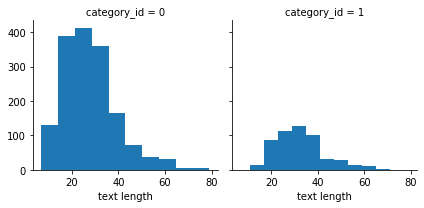

In [6]:
g=sns.FacetGrid(df_train, col='category_id')
g.map(plt.hist,'text length')

Create a boxplot of text length for each category_id.

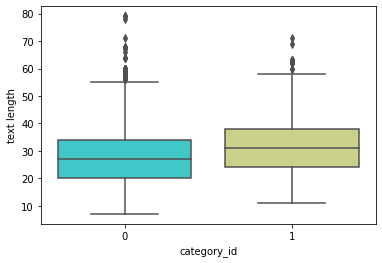

In [7]:
sns.boxplot(x='category_id', y='text length',data=df_train, palette='rainbow')

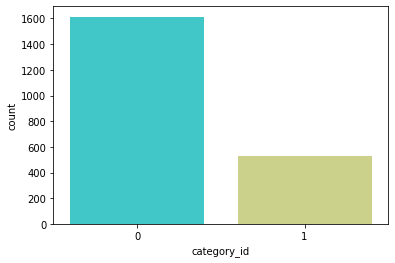

In [8]:
sns.countplot(x='category_id',data=df_train, palette='rainbow')

Data Overview

In [9]:
import matplotlib.pyplot as plt

#from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, STOPWORDS

print(df_train.shape)

(2142, 4)


In [10]:
df_train['category_id'].value_counts(normalize = True)

0    0.753035
1    0.246965
Name: category_id, dtype: float64

In [11]:
disaster_samples = df_train[df_train['category_id'] == 1]
fake_samples = df_train[df_train['category_id'] == 0]


In [12]:
for sample in disaster_samples['description_x'].sample(3, random_state=42):
    print(sample)
    print('\n=======\n')

vanguard intermediate-term investment-grade fund admiral shares


vanguard small cap index - a


pim total rt inst




In [13]:
for sample in fake_samples['description_x'].sample(3, random_state=42):
    print(sample)
    print('\n=======\n')

du pont ei de nemour


ishares msci southkorea cp etf div: 1.202


abbott labs




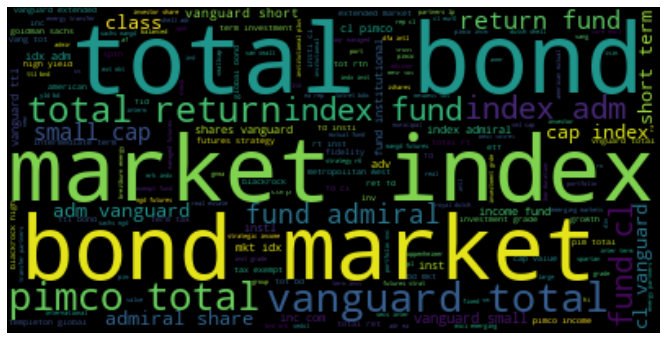

In [14]:
text = disaster_samples['description_x'].values

wc = WordCloud(max_font_size=60, background_color="black", max_words=2000, stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17),interpolation="bilinear")
plt.show()



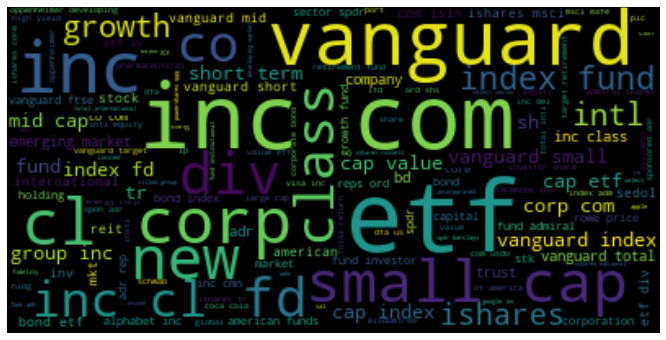

In [15]:
text = fake_samples['description_x'].values

wc = WordCloud(max_font_size=60, background_color="black", max_words=2000, stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(12,6))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17),interpolation="bilinear")
plt.show()


In [16]:
from sklearn.metrics import accuracy_score

In [17]:
constant_prediction = [0 for text in df_train['description_x']]
constant_accuracy_score = accuracy_score(df_train['category_id'], constant_prediction)

print(f'accuracy_score : {constant_accuracy_score}')

accuracy_score : 0.7530345471521942


Popular words differences

In [18]:
from collections import Counter

disaster_text = ' '.join(disaster_samples['description_x'].tolist())
disaster_words = disaster_text.split()
disaster_count = Counter(disaster_words)
disaster_count = pd.Series(disaster_count)
disaster_count = disaster_count.sort_values(ascending=False)

fake_text = ' '.join(fake_samples['description_x'].tolist())
fake_words = fake_text.split()
fake_count = Counter(fake_words)
fake_count = pd.Series(fake_count)
fake_count = fake_count.sort_values(ascending=False)

In [19]:
disaster_count.iloc[:10]

vanguard    180
total       158
bond        144
fund        135
index       121
cl          100
pimco        99
market       79
return       70
adm          63
dtype: int64

In [20]:
disaster_count[~disaster_count.index.str.lower().isin(STOPWORDS)].iloc[:20]

vanguard    180
total       158
bond        144
fund        135
index       121
cl          100
pimco        99
market       79
return       70
adm          63
admiral      54
shares       42
instl        39
inst         37
income       35
cap          34
fd           33
mkt          30
idx          27
small        24
dtype: int64

Modeling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

split to train test for validation purposes

In [26]:
X, y = df_train['description_x'], df_train['category_id']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:

count_vectorizer = CountVectorizer(binary=True)
log_reg = LogisticRegression(solver='liblinear', random_state=42)


fit model

In [29]:
count_vectorizer.fit(X_train)
X_train_vectorized = count_vectorizer.transform(X_train)

log_reg.fit(X_train_vectorized, y_train);

prediction


In [31]:
X_test_vectorized = count_vectorizer.transform(X_test)

prediction_train = log_reg.predict(X_train_vectorized)
prediction_test = log_reg.predict(X_test_vectorized)

In [32]:
accuracy_score(y_train, prediction_train), accuracy_score(y_test, prediction_test)

(0.9270286047869235, 0.8997668997668997)

Scikit-Learn Pipeline API

In [33]:
from sklearn.pipeline import Pipeline, FeatureUnion

count_vectorizer = CountVectorizer()
log_reg = LogisticRegression(solver='liblinear', random_state=42)

model = Pipeline([('count_vectorizer', count_vectorizer),  ('log_reg', log_reg)])

fitting

In [34]:
model.fit(X_train, y_train);

predict

In [35]:
accuracy_score(y_test, model.predict(X_test))

0.8951048951048951